In [1]:
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd

Using matplotlib backend: <object object at 0x7fc6088e7df0>
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats
from scipy.optimize import fsolve

In [3]:
alphatildes = {}
def alphatilde(alpha):
    if alpha not in alphatildes:
        alphatildes[alpha] = np.exp(-(fsolve(lambda x: 2*np.sqrt(x/np.pi)*np.exp(-x)+2*(1-stats.norm.cdf(np.sqrt(2*x)))-alpha, alpha)[0]))
    return(alphatildes[alpha])


In [4]:
def our_cs(X,alpha=0.05,t0s=np.array([100]),lamb=1):
    M,T = X.shape
    ts = np.arange(1,T+1)
    m1 = np.cumsum(X,1)/ts
    m2 = np.cumsum(X**2,1)/ts
    v2 = m2-m1**2
    w = np.roll(np.sqrt(v2),1,axis=1)
    w[:,0]  = 0
    w[w==0] = 1
    w = 1/w
    G = np.cumsum(w,1)
    center = np.cumsum(X*w,1)/G
    width = np.array([np.sqrt((ts+lamb)*(np.log(ts+lamb)-np.log(t0)-2*np.log(alphatilde(alpha))))/G+np.nan_to_num(np.inf*(ts<t0),nan=0,posinf=np.inf) for t0 in t0s])
    return (center, width)

def ramdas_cs_loglog(X,alpha=0.05,t0s=np.array([100])):
    M,T = X.shape
    ts = np.arange(1,T+1)
    m1 = np.cumsum(X,1)/ts
    m2 = np.cumsum(X**2,1)/ts
    v2 = m2-m1**2
    width = 1.7*np.sqrt(v2)*np.sqrt(np.log(np.log(2*ts))+0.72*np.log(10.4/alpha))/np.sqrt(ts)
    return (m1, np.array([width+np.nan_to_num(np.inf*(ts<t0),nan=0,posinf=np.inf) for t0 in t0s]))

def ramdas_cs_normmix(X,alpha=0.05,t0s=np.array([100])):
    M,T = X.shape
    ts = np.arange(1,T+1)
    m1 = np.cumsum(X,1)/ts
    m2 = np.cumsum(X**2,1)/ts
    v2 = m2-m1**2
    width = np.sqrt(v2)*np.sqrt(np.log(np.sqrt(ts+1)/alpha)*2*(1+1/ts)/ts)
    return (m1, np.array([width+np.nan_to_num(np.inf*(ts<t0),nan=0,posinf=np.inf) for t0 in t0s]))

def ramdas_cs_hoeff(X,alpha=0.05,t0s=np.array([100]),sig=0.5):
    M,T = X.shape
    ts = np.arange(1,T+1)
    m1 = np.cumsum(X,1)/ts
    width = 1.7*(sig*np.ones_like(m1))*np.sqrt(np.log(np.log(2*ts))+0.72*np.log(10.4/alpha))/np.sqrt(ts)
    return (m1, np.array([width+np.nan_to_num(np.inf*(ts<t0),nan=0,posinf=np.inf) for t0 in t0s]))

def naive_cs(X,alpha=0.05,t0s=np.array([100])):
    M,T = X.shape
    ts = np.arange(1,T+1)
    m1 = np.cumsum(X,1)/ts
    m2 = np.cumsum(X**2,1)/ts
    v2 = m2-m1**2
    width = stats.norm.ppf(1-alpha/2)*np.sqrt(v2)/np.sqrt(ts)
    return (m1, np.array([width+np.nan_to_num(np.inf*(ts<t0),nan=0,posinf=np.inf) for t0 in t0s]))


In [5]:
T = 200000
M = 500

case = 'bernoulli'
# case = 'poisson'

if case == 'bernoulli':
    mu = 0.5
    X = np.random.randint(2, size=(M,T))
else:
    mu = 1
    X = np.random.poisson(mu, size=(M,T))

In [6]:
t0s=np.unique((np.sqrt(2)**np.arange(25)).astype(np.int_))
alpha = 0.1
lamb = 1

In [7]:
center,width = our_cs(X, t0s=t0s, alpha=alpha, lamb = lamb)

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


In [8]:
center2,width2 = ramdas_cs_loglog(X, t0s=t0s)

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


In [9]:
center3,width3 = ramdas_cs_normmix(X, t0s=t0s)


/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


In [10]:
center4,width4 = naive_cs(X, t0s=t0s)

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


In [11]:
if case == 'bernoulli':
    center5,width5 = ramdas_cs_hoeff(X, t0s=t0s)

In [12]:
sig1=((mu<center-width)|(mu>center+width)).any(2).mean(1)

In [13]:
sig2=((mu<center2-width2)|(mu>center2+width2)).any(2).mean(1)

In [14]:
sig3=((mu<center3-width3)|(mu>center3+width3)).any(2).mean(1)

In [15]:
sig4=((mu<center4-width4)|(mu>center4+width4)).any(2).mean(1)

In [16]:
if case == 'bernoulli':
    sig5=((mu<center5-width5)|(mu>center5+width5)).any(2).mean(1)

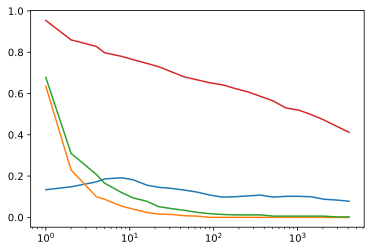

In [17]:
plot(t0s,sig1)
plot(t0s,sig2)
plot(t0s,sig3)
plot(t0s,sig4)
if case == 'bernoulli':
    plot(t0s,sig5)
xscale('log')

In [18]:
sigs = pd.concat((
    pd.DataFrame(dict(t0=t0s,sig=sig1,method='Ours')),
    pd.DataFrame(dict(t0=t0s,sig=sig2,method='AsympCS2')),
    pd.DataFrame(dict(t0=t0s,sig=sig3,method='AsympCS1')),
    pd.DataFrame(dict(t0=t0s,sig=sig4,method='NormCI')),
    pd.DataFrame(dict(t0=t0s,sig=sig5,method='HoeffCS')) if case == 'bernoulli' else None
))


In [19]:
sigs.to_csv(case+'1_sig.csv')

In [21]:
mh=mu*1.05
rej1=1+(((mh<center-width)|(mh>center+width)).argmax(axis=2)+np.nan_to_num(np.inf*(~((mh<center-width)|(mh>center+width))).all(2),nan=0,posinf=np.inf))#.mean(1)


/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
rej2=1+(((mh<center2-width2)|(mh>center2+width2)).argmax(axis=2)+np.nan_to_num(np.inf*(~((mh<center2-width2)|(mh>center2+width2))).all(2),nan=0,posinf=np.inf))#.mean(1)


/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [23]:
rej3=1+(((mh<center3-width3)|(mh>center3+width3)).argmax(axis=2)+np.nan_to_num(np.inf*(~((mh<center3-width3)|(mh>center3+width3))).all(2),nan=0,posinf=np.inf))#.mean(1)


/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [24]:
rej4=1+(((mh<center4-width4)|(mh>center4+width4)).argmax(axis=2)+np.nan_to_num(np.inf*(~((mh<center4-width4)|(mh>center4+width4))).all(2),nan=0,posinf=np.inf))#.mean(1)


/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [25]:
if case == 'bernoulli':
    rej5=1+(((mh<center5-width5)|(mh>center5+width5)).argmax(axis=2)+np.nan_to_num(np.inf*(~((mh<center5-width5)|(mh>center5+width5))).all(2),nan=0,posinf=np.inf))#.mean(1)


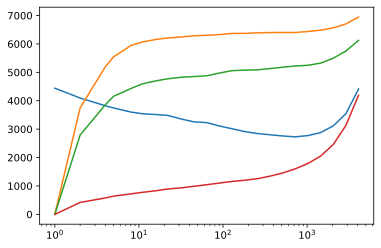

In [26]:
plot(t0s,rej1.mean(1))
plot(t0s,rej2.mean(1))
plot(t0s,rej3.mean(1))
plot(t0s,rej4.mean(1))
if case == 'bernoulli':
    plot(t0s,rej5.mean(1))
xscale('log')

In [27]:
rej = pd.concat((
    pd.DataFrame(rej1).stack().rename_axis(['t0', 'run']).reset_index(name='stoppingtime').assign(method='Ours').assign(t0=lambda x: t0s[x.t0]),
    pd.DataFrame(rej2).stack().rename_axis(['t0', 'run']).reset_index(name='stoppingtime').assign(method='AsympCS2').assign(t0=lambda x: t0s[x.t0]),
    pd.DataFrame(rej3).stack().rename_axis(['t0', 'run']).reset_index(name='stoppingtime').assign(method='AsympCS1').assign(t0=lambda x: t0s[x.t0]),
    pd.DataFrame(rej4).stack().rename_axis(['t0', 'run']).reset_index(name='stoppingtime').assign(method='NormCI').assign(t0=lambda x: t0s[x.t0]),
    pd.DataFrame(rej5).stack().rename_axis(['t0', 'run']).reset_index(name='stoppingtime').assign(method='HoeffCS').assign(t0=lambda x: t0s[x.t0]) if case == 'bernoulli' else None
))


In [28]:
rej.to_csv(case+'1_105_rej.csv')

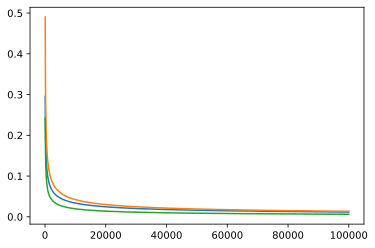

In [346]:
plot(width[10].mean(0))
plot(width2[10].mean(0))
plot(width3[10].mean(0))

In [361]:
for i in range(10):
    plot(center[i]+width[10,i],'b',alpha=.4)
    plot(center[i]-width[10,i],'b',alpha=.4)
    plot(center2[i]+width2[10,i],'r',alpha=.4)
    plot(center2[i]-width2[10,i],'r',alpha=.4)
    plot(center3[i]+width3[10,i],'g',alpha=.4)
    plot(center3[i]-width3[10,i],'g',alpha=.4)
    xscale('log')